# CML processing with radar wet-dry and spatial interpolation of points and lines 

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. Get and project example data

In [9]:
# Fetches 8 days from OpenMRG
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [10]:
# Reduce dataset, selecting 1 hour of data
start = "2015-07-25T13:00"
end = "2015-07-25T14:00"
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end))
ds_gauges_municp = ds_gauges_municp.sel(time = slice(start, end)) 
ds_gauge_smhi = ds_gauge_smhi.sel(time = slice(start, end))

In [11]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauge_smhi.lon, ds_gauge_smhi.lat, ref_str
    )
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

In [12]:
# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

In [14]:
# Resample units of reference data to common 15 minute resolution
da_rad_15_min = (ds_rad.rainfall_radar*5/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min
da_gauges_municp_15min = ds_gauges_municp.rainfall_amount.resample(time="15min", label='right', closed='right').sum() # from sum 1min -> sum 15min 
da_gauge_smhi_15min = ds_gauge_smhi.rainfall_amount # Already at correct resolution
ds_cmls_example_15min = (ds_cmls.isel(sublink_id = 0).R_example/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min

<Axes: xlabel='lon', ylabel='lat'>

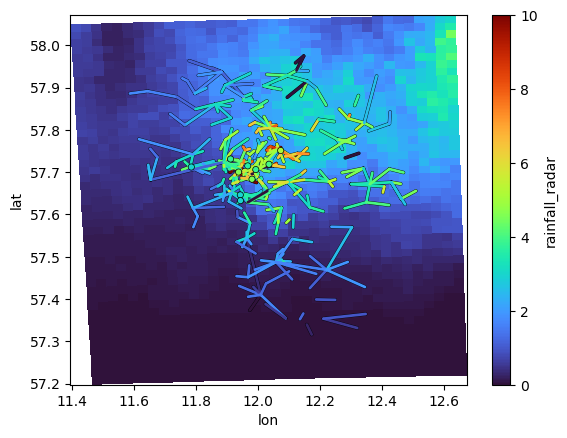

In [16]:
# Plot situation
plg.plot_map.plot_plg(
    da_grid=da_rad_15_min.sum(dim="time"),
    da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    da_cmls=ds_cmls_example_15min.sum(dim = 'time'),
    vmin=0,
    vmax=10,
)


## 2. Radar wet/dry CML processing

In [18]:
# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

In [19]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Resample to sum 1 minute to make comparable to CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# Rolling std wet/Dry for reference
#ds_cmls["wet"] = ds_cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8

In [20]:
# estiamte the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)


# 2. Interpolate rainfall maps

In [13]:
# beware: 
# - the lat and lon coordinates should be converted to UTM (we skip this part)
# - using the link midpoint is an approximation, more advanced teqniques exists. 

<img src="https://gisgeography.com/wp-content/uploads/2016/05/IDW-3Points.png" alt="drawing" width="600"/>


In [14]:
# define timestep 
time = '2015-08-27T01:55'
# load radar reference data
radar_ref = xr.open_dataset('../data/cml/openMRG_example_rad.nc')

# get the center of each CML
cmls["lat_center"] = (cmls.site_0_lat + cmls.site_1_lat) / 2
cmls["lon_center"] = (cmls.site_0_lon + cmls.site_1_lon) / 2

### 5.1 Inverse distance weighting (IDW)

In [15]:
# define the properties of the IDW algorithm
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15,  # <------------- number of neighbors
    p=2,  # <------------------ weighting parameter
    exclude_nan=True,  # <----- remove nan values from interpolation
    max_distance=0.4,  # <----- upper bound distance
)

In [16]:
# interpolate one hour of rainfall using the lat and lon of the link midpoint. 
R_grid_idw = idw_interpolator(
    x=cmls.lon_center,  # <------------------------- input x coordinates
    y=cmls.lat_center,  # <------------------------- input y coordinates
    z=cmls.R.sel(time=time),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [17]:
radar_ref['R_grid_idw'] = (('y', 'x'), R_grid_idw)

### 5.2 Ordinary Kriging

In [18]:
kriging_interpolator = pycml.spatial.interpolator.OrdinaryKrigingInterpolator(
    nlags=6,
    variogram_model='spherical',
    #variogram_parameters=None,
    weight=True,
    n_closest_points=15,
)

In [19]:
R_grid_kriging = kriging_interpolator(
    x=cmls.lon_center.where(~np.isnan(cmls.R.sel(time=time)), drop = True), 
    y=cmls.lat_center.where(~np.isnan(cmls.R.sel(time=time)), drop = True), 
    z=cmls.R.sel(time=time).where(~np.isnan(cmls.R.sel(time=time)), drop = True),  # <----- rainfall values
    xgrid=radar_ref.lon.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.lat.values,  # <--------- target grid y coordinates
)

In [20]:
radar_ref['R_grid_kriging'] = (('y', 'x'), R_grid_kriging)

### Plot IDW and Kriging results

Text(0.5, 1.0, 'radar reference')

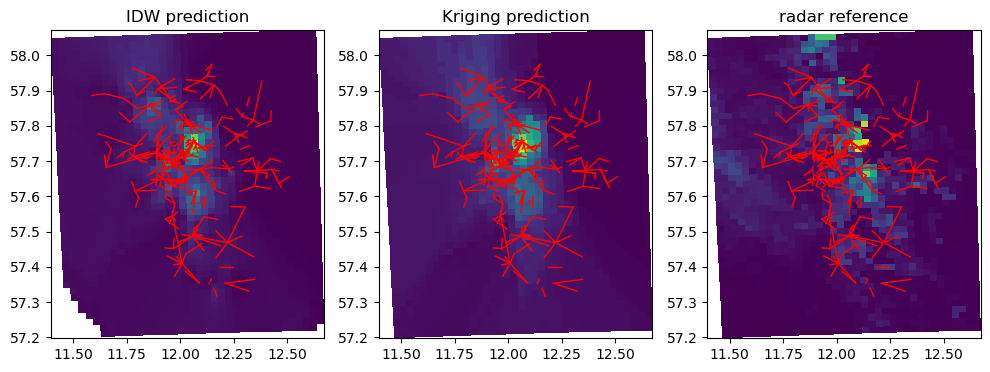

In [21]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref.lon.values, radar_ref.lat.values, radar_ref['R_grid_kriging'])
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref.lon.values, 
    radar_ref.lat.values, 
    radar_ref.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


# Comparing IWD and Kriging to the radar reference

In [22]:
# crop the radar and estimated rainfall fields so that we compare the interpolated pixels
radar_ref_crop = radar_ref.isel(x = slice(10, 30), y = slice(10, 40))

Text(0.5, 1.0, 'radar reference')

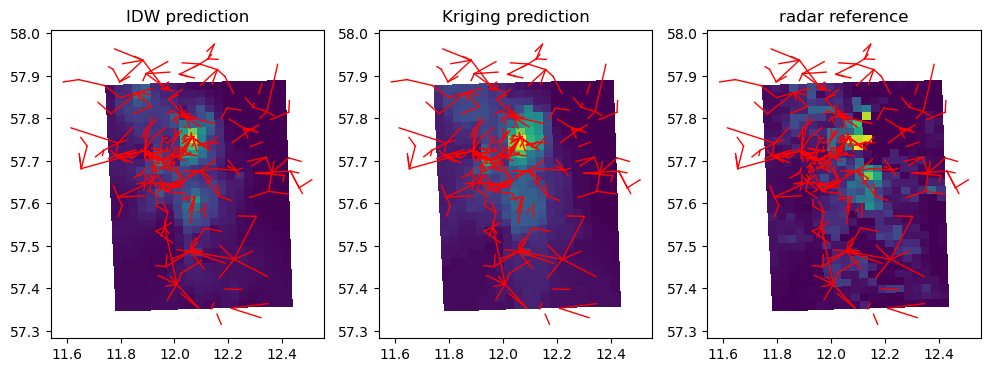

In [23]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))
ax[0].set_title('IDW prediction')
ax[0].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_idw)
for cml_i in range(cmls.cml_id.size):
    ax[0].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )    

ax[1].set_title('Kriging prediction')
ax[1].pcolormesh(radar_ref_crop.lon.values, radar_ref_crop.lat.values, radar_ref_crop.R_grid_kriging)
for cml_i in range(cmls.cml_id.size):
    ax[1].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   

ax[2].pcolormesh(
    radar_ref_crop.lon.values, 
    radar_ref_crop.lat.values, 
    radar_ref_crop.R.sel(time = time, method = 'nearest'),
    #cmap=plt.get_cmap("YlGnBu", 12),
)
for cml_i in range(cmls.cml_id.size):
    ax[2].plot(
        [cmls.isel(cml_id = cml_i).site_0_lon, 
         cmls.isel(cml_id = cml_i).site_1_lon],
        [cmls.isel(cml_id = cml_i).site_0_lat, 
         cmls.isel(cml_id = cml_i).site_1_lat],
        "red",
        linewidth=1,
    )   
ax[2].set_title('radar reference');


Text(0.5, 1.0, 'Kriging')

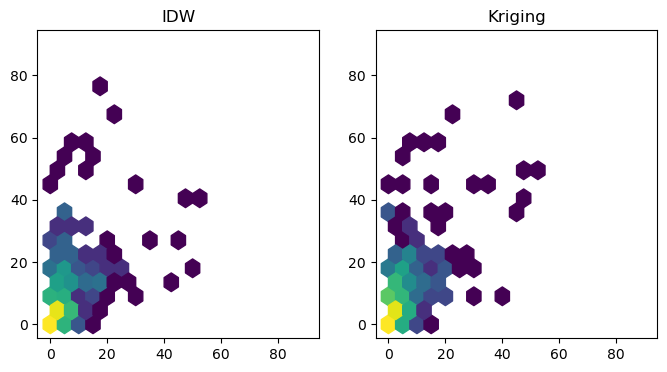

In [24]:
fig, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_idw.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),

)
ax[0].set_title('IDW')
ax[1].hexbin(
    radar_ref_crop.R.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_kriging.values,
    bins = 'log',
    gridsize = 18,
    extent = (0, 90, 0, 90),
)
ax[1].set_title('Kriging');


# Exercises:

#### Exercise 1
Interpolate and plot another timestep of the dataset and compare it to the reference

#### Exercise 2
Compute and plot an aggregated rainfall map for the time interval '2015-08-27T01:00' -> '2015-08-27T02:00'. Hint: Resample the CML rainfall ammounts using (cmls.R.resample(time = '60T').sum() and radar data using radar_ref.resample(time = '60T').sum(). Then select the timestep of interest. Interpolate the aggregated CML values using IDW or Kriging. Compare the results to the reference using a scatterplot. How does different aggregation times affect the results? 

#### Exercise 3


Draw randomly 40 CMLs from timestep '2015-08-27T01:55'. Interpolate using IDW and Kriging. How does the interpolated maps from IDW and Kriging differ compared to the radar if you include more links? Hint: You can draw random integers by np.random.randint(0, 100, 40) and select them using cmls.isel(cml_id = np.random.randint(0, 100, 40)). 